<a href="https://colab.research.google.com/github/PartyForYou/MachineLearningProgramming/blob/main/5_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

https://bit.ly/hg-05-2

# 교차 검증과 그리드 서치

## 검증 세트

In [ ]:
import pandas as pd

wine = pd.read_csv('https://bit.ly/wine_csv_data')

In [ ]:
data = wine[['alcohol', 'sugar', 'pH']].to_numpy()
target = wine['class'].to_numpy()

In [ ]:
from sklearn.model_selection import train_test_split

train_input, test_input, train_target, test_target = train_test_split(
    data, target, test_size=0.2, random_state=42)

In [ ]:
sub_input, val_input, sub_target, val_target = train_test_split(
    train_input, train_target, test_size=0.2, random_state=42)

In [ ]:
print(sub_input.shape, val_input.shape)

(4157, 3) (1040, 3)


In [ ]:
from sklearn.tree import DecisionTreeClassifier

dt = DecisionTreeClassifier(random_state=42)
dt.fit(sub_input, sub_target)

print(dt.score(sub_input, sub_target))
print(dt.score(val_input, val_target))

0.9971133028626413
0.864423076923077


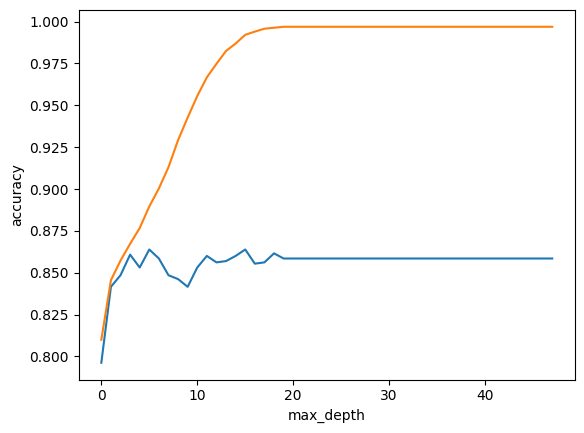

0.8572253223013276
0.8484615384615385


In [ ]:
train_score = []
test_score = []
for i in range(2, 50):
  model = DecisionTreeClassifier(max_depth = i, random_state=42)
  model.fit(train_input, train_target)
  train_score.append(model.score(train_input, train_target))
  test_score.append(model.score(test_input, test_target))
import matplotlib.pyplot as plt
plt.plot(test_score)
plt.plot(train_score)
plt.xlabel('max_depth')
plt.ylabel('accuracy')
plt.show()

model = DecisionTreeClassifier(max_depth = 4, min_impurity_decrease=0.0005)
model.fit(train_input, train_target)

print(model.score(train_input, train_target))
print(model.score(test_input, test_target))



## 교차 검증

검증 세트를 떼어 내어 평가하는 과정을 여러번 반복함

In [ ]:
from sklearn.model_selection import cross_validate

scores = cross_validate(dt, train_input, train_target)
print(scores)

{'fit_time': array([0.01352882, 0.00734591, 0.00759268, 0.00887394, 0.00731468]), 'score_time': array([0.00128722, 0.00115228, 0.00118613, 0.00119162, 0.00117111]), 'test_score': array([0.86923077, 0.84615385, 0.87680462, 0.84889317, 0.83541867])}


fit time: 훈련할 때 걸린 시간

test_score: 검증 점수

In [ ]:
import numpy as np

print(np.mean(scores['test_score']))

0.855300214703487


**주의할 점**

cross_validate()는 훈련 세트를 섞어 폴드를 나누지 않음

만약 train_test_split()를 하지 않았다면 분할기로 지정해야 함

cross_validate()는 회귀모델일 경우 KFold 분할기를 사용하고 분류 모델일 경우 StratifiedKFold를 사용

섞지 않는 것이 디폴트이므로 따로 설정해야 함

In [ ]:
from sklearn.model_selection import StratifiedKFold

scores = cross_validate(dt, train_input, train_target, cv=StratifiedKFold())
print(np.mean(scores['test_score']))

0.855300214703487


In [ ]:
splitter = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
scores = cross_validate(dt, train_input, train_target, cv=splitter)
print(np.mean(scores['test_score']))

0.8574181117533719


## 하이퍼파라미터 튜닝

**그리드 서치**

하이퍼파라미터 탐색과 교차 검증을 한 번에 수행

즉, cross_validate()함수를 호출할 필요가 없음

예제: 결정 트리 모델에서 min_impurity_decrease 최적값 찾기

GridSearchCV 클래스를 import하고 탐색할 매개변수와 탐색할 값의 리스트를 딕셔너리로 만듦

조건생성

In [ ]:
from sklearn.model_selection import GridSearchCV

params = {'min_impurity_decrease': [0.0001, 0.0002, 0.0003, 0.0004, 0.0005]}

In [ ]:
gs = GridSearchCV(DecisionTreeClassifier(random_state=42), params, n_jobs=-1)

GridSearchCV의 cv 매개변수 기본값은 5이므로 params에서 설정한 5개의 min_inpurity_decrease 별로 결정 트리를 5번 실행

즉, 25번의 결정 트리 모델을 훈련

n_jobs: 병렬 실행에서 사용할 CPU 코어 수이며, -1이면 모든 코어를 사용

훈련

In [ ]:
gs.fit(train_input, train_target)

GridSearchCV(estimator=DecisionTreeClassifier(random_state=42), n_jobs=-1,
             param_grid={'min_impurity_decrease': [0.0001, 0.0002, 0.0003,
                                                   0.0004, 0.0005]})

In [ ]:
dt = gs.best_estimator_
print(dt.score(train_input, train_target))

0.9615162593804117


In [ ]:
print(gs.best_params_)

{'min_impurity_decrease': 0.0001}


In [ ]:
print(gs.cv_results_['mean_test_score'])

[0.86819297 0.86453617 0.86492226 0.86780891 0.86761605]


In [ ]:
best_index = np.argmax(gs.cv_results_['mean_test_score'])
print(gs.cv_results_['params'][best_index])

{'min_impurity_decrease': 0.0001}


In [ ]:
params = {'min_impurity_decrease': np.arange(0.0001, 0.001, 0.0001),
          'max_depth': range(5, 20, 1),
          'min_samples_split': range(2, 100, 10)
          }

In [ ]:
gs = GridSearchCV(DecisionTreeClassifier(random_state=42), params, n_jobs=-1)
gs.fit(train_input, train_target)

GridSearchCV(estimator=DecisionTreeClassifier(random_state=42), n_jobs=-1,
             param_grid={'max_depth': range(5, 20),
                         'min_impurity_decrease': array([0.0001, 0.0002, 0.0003, 0.0004, 0.0005, 0.0006, 0.0007, 0.0008,
       0.0009]),
                         'min_samples_split': range(2, 100, 10)})

In [ ]:
print(gs.best_params_)


{'max_depth': 14, 'min_impurity_decrease': 0.0004, 'min_samples_split': 12}


In [ ]:
print(np.max(gs.cv_results_['mean_test_score']))

0.8683865773302731


In [ ]:
params = {'min_impurity_decrease': np.arange(0.0001, 0.001, 0.0001),
          'max_depth': range(5, 20, 1),
          'min_samples_split': range(2, 100, 10)
          }
dt = DecisionTreeClassifier(random_state = 42)
gs = GridSearchCV(dt, params, n_jobs=-1)
gs.fit(train_input, train_target)

print(gs.best_params_)

{'max_depth': 14, 'min_impurity_decrease': 0.0004, 'min_samples_split': 12}


### 랜덤 서치

In [ ]:
from scipy.stats import uniform, randint

uniform : 실수값

randint: 정수값

In [ ]:
rgen = randint(0, 10)
rgen.rvs(10)

array([9, 4, 3, 1, 0, 7, 6, 9, 3, 2])

In [ ]:
np.unique(rgen.rvs(1000), return_counts=True)

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 array([ 77, 110, 114, 104,  84, 116, 105,  93,  85, 112]))

In [ ]:
ugen = uniform(0, 1)
ugen.rvs(10)

array([0.92882876, 0.5099607 , 0.0685644 , 0.60772638, 0.07970688,
       0.30667203, 0.1713515 , 0.51519987, 0.74993595, 0.63016551])

결정 트리 모델에서 min_impurity, decrease, max_depth, min_samples_split, min_samples_leaf 최적값 찾기

In [ ]:
params = {'min_impurity_decrease': uniform(0.0001, 0.001),
          'max_depth': randint(20, 50),
          'min_samples_split': randint(2, 25),
          'min_samples_leaf': randint(1, 25),
          }

In [ ]:
from sklearn.model_selection import RandomizedSearchCV

gs = RandomizedSearchCV(DecisionTreeClassifier(random_state=42), params,
                        n_iter=100, n_jobs=-1, random_state=42)
gs.fit(train_input, train_target)

RandomizedSearchCV(estimator=DecisionTreeClassifier(random_state=42),
                   n_iter=100, n_jobs=-1,
                   param_distributions={'max_depth': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7bb6090040d0>,
                                        'min_impurity_decrease': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x7bb609006110>,
                                        'min_samples_leaf': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7bb609005510>,
                                        'min_samples_split': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7bb609006500>},
                   random_state=42)

반복 횟수를 정해야함

In [ ]:
print(gs.best_params_)

{'max_depth': 39, 'min_impurity_decrease': 0.00034102546602601173, 'min_samples_leaf': 7, 'min_samples_split': 13}


In [ ]:
print(np.max(gs.cv_results_['mean_test_score']))

0.8695428296438884


In [ ]:
dt = gs.best_estimator_

print(dt.score(test_input, test_target))

0.86


**주의**

교차검증, 그리드 서치, 랜덤 서치는 모델을 훈련하는 것이 아니라 검증하는 것임

즉, 적절한 하이퍼파라미터를 찾는데 사용해야 함

In [ ]:
import pandas as pd

wine = pd.read_csv('https://bit.ly/wine_csv_data')

In [ ]:
data = wine[['alcohol', 'sugar', 'pH']].to_numpy() #Data타입 -> Numpy타입
target = wine['class'].to_numpy()

실습

In [ ]:
from sklearn.model_selection import train_test_split

train_input, test_input, train_target, test_target = train_test_split(
    data, target, test_size=0.2, random_state=42) #stratify = target(stratify는 비율고려해서 분류해줌!!)
sub_input, val_input, sub_target, val_target = train_test_split(
    train_input, train_target, test_size=0.2, random_state=42)

#정규
from sklearn.preprocessing import StandardScaler

ss = StandardScaler()
ss.fit(train_input)

train_scaled = ss.transform(train_input)
test_scaled = ss.transform(test_input)

#결정 트리
from sklearn.tree import DecisionTreeClassifier
#그리드 서치
print("그리드 서치")
from sklearn.model_selection import GridSearchCV
params = {'min_impurity_decrease': np.arange(0.0001, 0.001, 0.0001),
          'max_depth': range(5, 20, 1),
          'min_samples_split': range(2, 100, 10)
          }
dt = DecisionTreeClassifier(random_state = 42)
gs = GridSearchCV(dt, params, n_jobs=-1)
gs.fit(train_input, train_target)
print(gs.best_params_)
dt = gs.best_estimator_
print(dt.score(train_input, train_target))
print(dt.score(test_input, test_target))


#랜덤 서치
print("랜덤 서치")
from scipy.stats import uniform, randint
params = {'min_impurity_decrease': uniform(0.0001, 0.001),
          'max_depth': randint(20, 50),
          'min_samples_split': randint(2, 25),
          'min_samples_leaf': randint(1, 25),
          }
from sklearn.model_selection import RandomizedSearchCV

gs = RandomizedSearchCV(DecisionTreeClassifier(random_state=42), params,
                        n_iter=100, n_jobs=-1, random_state=42)
gs.fit(train_input, train_target)
print(gs.best_params_)
dt = gs.best_estimator_
print(dt.score(train_input, train_target))
print(dt.score(test_input, test_target))

그리드 서치
{'max_depth': 14, 'min_impurity_decrease': 0.0004, 'min_samples_split': 12}
0.892053107562055
0.8615384615384616
랜덤 서치
{'max_depth': 39, 'min_impurity_decrease': 0.00034102546602601173, 'min_samples_leaf': 7, 'min_samples_split': 13}
0.8928227823744468
0.86


## 확인문제

In [ ]:
gs = RandomizedSearchCV(DecisionTreeClassifier(splitter='random', random_state=42), params,
                        n_iter=100, n_jobs=-1, random_state=42)
gs.fit(train_input, train_target)

RandomizedSearchCV(estimator=DecisionTreeClassifier(random_state=42,
                                                    splitter='random'),
                   n_iter=100, n_jobs=-1,
                   param_distributions={'max_depth': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7bb6090040d0>,
                                        'min_impurity_decrease': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x7bb609006110>,
                                        'min_samples_leaf': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7bb609005510>,
                                        'min_samples_split': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7bb609006500>},
                   random_state=42)

In [ ]:
print(gs.best_params_)
print(np.max(gs.cv_results_['mean_test_score']))

dt = gs.best_estimator_
print(dt.score(test_input, test_target))

{'max_depth': 43, 'min_impurity_decrease': 0.00011407982271508446, 'min_samples_leaf': 19, 'min_samples_split': 18}
0.8458726956392981
0.786923076923077
